In [1]:
import gym
from gym import spaces
from gym_unbalanced_disk import UnbalancedDisk, UnbalancedDisk_exp
import numpy as np
import time


# discretize action
class Discretize(gym.Wrapper):
    def __init__(self, env, nvec = 20):
        super(Discretize, self).__init__(env) #sets self.env
        self.nvec = nvec
        self.action_space = gym.spaces.Discrete(self.nvec)
        self.alow, self.ahigh = env.action_space.low, env.action_space.high

    def step(self, action):
        action = self.opt_action(action)
        return self.env.step(action) #b)

    def reset(self):
        return self.env.reset()

    def random_action(self):
        action = self.env.action_space.sample()
        return ((action - self.alow)/(self.ahigh - self.alow)*self.nvec).astype(int) # discretize action

    def opt_action(self, action):
        action = action / self.nvec *(self.ahigh - self.alow) + self.alow
        return action

def normalization(theta):
    return (theta+np.pi)%(2*np.pi) - np.pi

class UnbalancedDisk_limit(UnbalancedDisk):
    """limit theta to [-pi,pi]"""
    def __init__(self, umax=3., dt = 0.025):
        super(UnbalancedDisk_limit, self).__init__(umax=umax, dt=dt)
        low = [-np.pi,-40.]
        high = [np.pi,40.]
        weight_omega, weight_action = 0.2, 1e-3
        self.observation_space = spaces.Box(low=np.array(low,dtype=np.float32),high=np.array(high,dtype=np.float32),shape=(2,))
        self.reward_fun = lambda self: (-18*(np.pi-np.abs(normalization(self.th)))**2 - weight_omega *self.omega **2 - weight_action*self.u**2).item()

    def get_obs(self):
        self.th_noise = self.th + np.random.normal(loc=0,scale=0.001) #do not edit
        self.omega_noise = self.omega + np.random.normal(loc=0, scale=0.001) #do not edit
        return np.array([normalization(self.th_noise), self.omega_noise]) #change anything here


In [3]:
from stable_baselines3 import DQN

max_episode_steps = 1000
total_timesteps = 340000
nvec = 20
lr = 0.008

env = UnbalancedDisk_limit(umax=3., dt = 0.025)
env = gym.wrappers.time_limit.TimeLimit(env,max_episode_steps)
env = Discretize(env,nvec=nvec)


# model = DQN("MlpPolicy", env, learning_rate=lr, verbose=1, train_freq=10, tensorboard_log=log_dir)
# model.learn(total_timesteps=total_timesteps)
# model.save(f'DQN_Best_{total_timesteps}')
model = DQN.load("model/DQN_best")

## Evaluating RL model after training
# mean, std = evaluate_policy(model, env, n_eval_episodes=10)
# print(f"Mean = {mean: .4f}, Standard deviation = {std: .4f}")

In [7]:
theta = []
omega = []
rewards = []
cum_rew = 0
cum_rewards = []

obs = env.reset()
try:
    for _ in range(500):
        action, _states = model.predict(obs)
        obs, reward, done, info = env.step(action)
        theta.append(obs[0])
        omega.append(obs[1])
        rewards.append(reward)
        cum_rew += reward
        cum_rewards.append(cum_rew)
        env.render()
        # print(action)
        time.sleep(1/60)
finally:
    env.close()

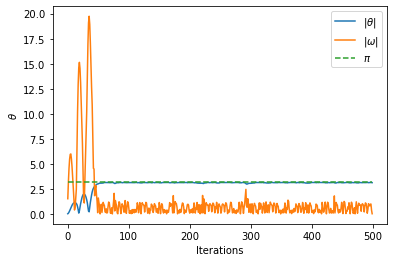

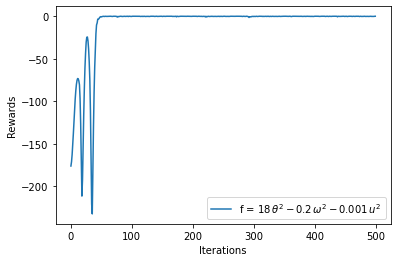

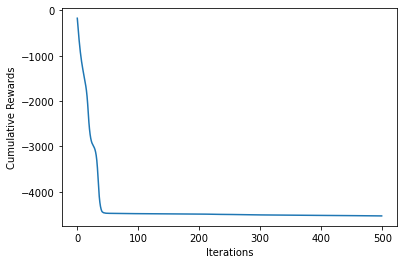

In [9]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.plot(np.abs(theta),label='$|\\theta|$')
plt.plot(np.abs(omega),label='$|\omega|$')
plt.plot([np.pi]*len(theta),'--',label='$\pi$')
plt.xlabel('Iterations')
plt.ylabel(r'$\theta$')
plt.legend()
plt.show()

plt.plot(rewards, label='f = $18\,\\theta^2 - 0.2\,\omega^2 - 0.001\,u^2$')
plt.xlabel('Iterations')
plt.ylabel('Rewards')
plt.legend()
plt.show()

plt.plot(cum_rewards)
plt.xlabel('Iterations')
plt.ylabel('Cumulative Rewards')
plt.show()